In [1]:
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
import lib.utils_RSA as rsa
from lib.algos import *
from scipy.spatial import procrustes as scipro


In [32]:
dataset = 'ecoVal'
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
path2activations = f'/data/alban/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 2048)

In [33]:
#### Uncomment if want to perform vector normalization.
for i, model in enumerate(models):
    activations[model] = ((activations[model].T)/np.linalg.norm(activations[model], axis = 1)).T


(28250, 2048)

In [34]:
#### Compute RDMs performing squared euclidean distance as a metric (to be equivalent to CKA methods, cf. Williams, 2024)
RDMs = {}
for i, model in enumerate(models):
    RDMs[model] = sklearn.metrics.pairwise.euclidean_distances(activations[model], squared=True)


In [20]:
#### Uncomment if want to perform matrix centering (for CKA equivalence)


In [7]:
SIMs = {}
#for model in models:
#    SIMs[model] = {}
#for i, model1 in enumerate(models[:-1]):
#    for j, model2 in enumerate(models[i+1:]):
#        SIMs[model1][model2] = list()
#        SIMs[model1][model2].append(rsa.Compute_sim_RDMs(RDMs[model1], RDMs[model2]))



In [9]:
### Run custom procrustes analysis
#d, Z, T = procrustes(activations['saycam'], activations['ego'])
### Run scipy procrustes analysis as a control
#mtx1, mtx2, dsci = scipro(activations['saycam'], activations['ego'])
#print([d, dsci])
### --> Both algos agree with each other, and the disparity measures are pretty high (somewhat unexpectedly)

[np.float32(0.7038437), np.float64(0.7038432856958128)]


In [35]:
### check if images were shown in the same order
imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[7]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate


#np.array(imagelist).reshape(-1, nb_per_cat)[0]

In [51]:
### Compute representational delineation for each category and model
delineation = {}
delineated_categories = {}
for model in models:
    delineation_tmp = np.zeros(len(listcat))
    RDM = RDMs[model]
    for c, cat in enumerate(listcat):
        cat_RDM = RDM[c*nb_per_cat:(c+1)*nb_per_cat, c*nb_per_cat:(c+1)*nb_per_cat] # square matrix of nb_cat x nb_cat
        noncat_RDM = np.concatenate([RDM[c*nb_per_cat:(c+1)*nb_per_cat, :c*nb_per_cat], RDM[c*nb_per_cat:(c+1)*nb_per_cat, (c+1)*nb_per_cat:]], axis =1) # Rectangular matrix of nb_cat x (n-nb_cat)
        upper_indices = np.triu_indices(nb_per_cat, k=1)  # k=1 excludes diagonal
        sim_withincat = cat_RDM[upper_indices].mean() # Compute similarity within the category
        sim_withoutcat = noncat_RDM.mean() # Compute similarity without the category
        delineation_tmp[c] = sim_withincat/sim_withoutcat
    delineation[model] = np.sort(delineation_tmp)
    delineated_categories[model] = np.array(listcat)[np.argsort(delineation_tmp)]




In [49]:
import math
def plot_stats(SIMs, submodels, labels = ['label1', 'label2']):
    '''plot the similarities as a function of layer depth.
    Plot is a subplot of adaptative size, depending on the length of the list submodel given.
    '''
    nb_subs = len(submodels) # Number of subs
    sqrt = np.sqrt(nb_subs)
    cols = math.ceil(sqrt)
    rows = math.ceil(nb_subs // sqrt)
    while (cols*rows)<(nb_subs):
        rows =rows + 1 ## compute the number of columns and rows
    fig, subs = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(cols*2+1, rows*2+1)) # adaptative size
    count = 0
    minval = 1
    maxval = 0
    for i, model in enumerate(submodels):
        minval = min(minval, np.amin(SIMs[model]))
        maxval = max(maxval, np.amax(SIMs[model]))
        if rows ==1:
            subs[count%cols].plot(SIMs[model])
            subs[count%cols].set_title(f'{model}')
        else:
            subs[count//cols, count%cols].plot(SIMs[model])
            subs[count//cols, count%cols].set_title(f'{model}')
            count+=1
    maxval = min(maxval, 1.1)
    plt.ylim(np.round(minval,1)-0.1, np.round(maxval,1)+0.1)
    if rows == 1:
        subs[0].set_ylabel(labels[1])
        for sub in subs:
            sub.set_xlabel(labels[0])
    else:
        for sub in subs[-1]:
            sub.set_xlabel(labels[0])
        for sub in subs[:,0]:
            sub.set_ylabel(labels[1])

    fig.tight_layout()
    plt.show()
    plt.close()

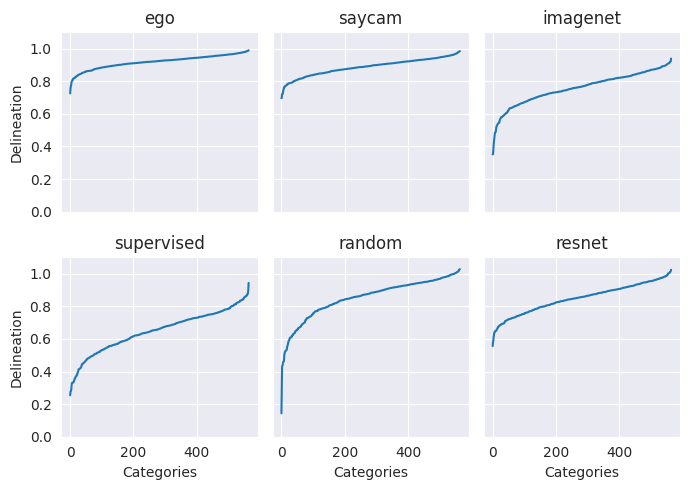

['1073_fireworks' '0156_moon' '0089_bus' '2144_newsstand' '0812_coin'
 '0005_house' '2400_geyser' '0082_kitchen' '0266_gravel' '0009_car'
 '1043_mall' '2098_odometer' '1367_sphinx' '2112_photocopier'
 '0857_waterfall' '0617_taco' '0847_jaguar' '1156_nacho' '0093_pizza'
 '1933_flashbulb']
['0089_bus' '1073_fireworks' '1612_forklift' '2144_newsstand'
 '0082_kitchen' '0005_house' '2400_geyser' '1043_mall' '0009_car'
 '2112_photocopier' '1367_sphinx' '1515_waterspout' '0857_waterfall'
 '0156_moon' '0443_snowplow' '1933_flashbulb' '0149_truck' '2972_rainbow'
 '0508_croissant' '0265_steak']
['0847_jaguar' '2098_odometer' '2400_geyser' '1129_zebra' '1892_panda'
 '1335_dragonfly' '0209_leopard' '2186_cheetah' '0132_tiger'
 '0764_gondola' '0443_snowplow' '1787_koala' '0517_bumblebee'
 '1673_dishrag' '0089_bus' '0857_waterfall' '0168_elephant'
 '0721_hedgehog' '0082_kitchen' '1015_hay']
['1829_blimp' '1892_panda' '2186_cheetah' '0909_flea' '0847_jaguar'
 '2098_odometer' '1264_mantis' '1129_zebra

In [52]:
plot_stats(delineation, models,  ['Categories', 'Delineation'])
for model in models:
    print(delineated_categories[model][:20])
for model in models:
    print(delineated_categories[model][-20:])

In [37]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = cat_activations[model].reshape(-1, nb_per_cat, shape[-1])

In [39]:
### Compute the activation variance within a category and normalize by the average variance
sorted_stats = {}
sorted_cats = {}
for model in models:
    var = np.var(cat_activations[model], axis = (0,1))
    cat_var = np.var(cat_activations[model], axis = 1)
    normalized_cat_var = cat_var/var
    mean_normalized_cat_var = normalized_cat_var.mean(-1)
    sorted_stats[model] = np.sort(mean_normalized_cat_var)
    sorted_cats[model] = np.array(listcat)[np.argsort(mean_normalized_cat_var)]

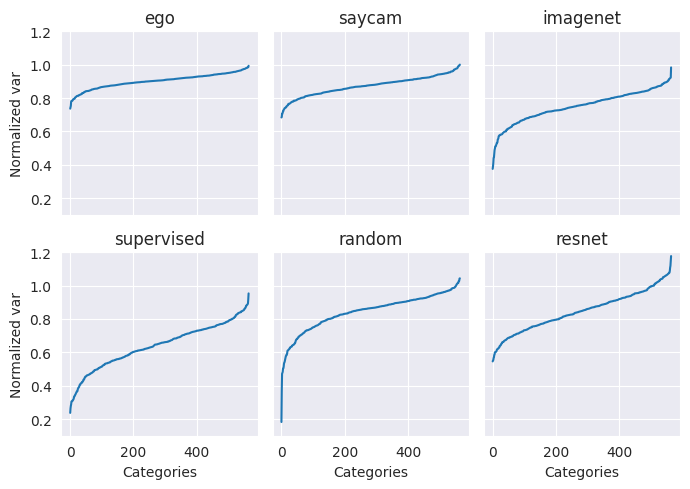

['1073_fireworks' '0089_bus' '2144_newsstand' '2400_geyser' '0005_house'
 '0617_taco' '0156_moon' '0009_car' '0082_kitchen' '1043_mall'
 '0857_waterfall' '1367_sphinx' '1156_nacho' '0812_coin' '0659_carousel'
 '0265_steak' '0847_jaguar' '0093_pizza' '0397_noodles' '0443_snowplow']
['1612_forklift' '0089_bus' '0082_kitchen' '1073_fireworks' '1367_sphinx'
 '2400_geyser' '2144_newsstand' '0005_house' '1043_mall' '0443_snowplow'
 '0508_croissant' '1892_panda' '2112_photocopier' '0009_car'
 '0857_waterfall' '0265_steak' '0617_taco' '1933_flashbulb'
 '1655_steamroller' '0149_truck']
['0847_jaguar' '2400_geyser' '2098_odometer' '1129_zebra' '1892_panda'
 '1335_dragonfly' '0443_snowplow' '0209_leopard' '0132_tiger' '1787_koala'
 '0764_gondola' '2186_cheetah' '0082_kitchen' '0089_bus' '0857_waterfall'
 '0517_bumblebee' '0168_elephant' '0721_hedgehog' '0617_taco'
 '2144_newsstand']
['1829_blimp' '1892_panda' '2186_cheetah' '0909_flea' '2098_odometer'
 '0847_jaguar' '0764_gondola' '1129_zebra' '1

In [41]:
plot_stats(sorted_stats,models,  ['Categories', 'Normalized var'])
for model in models:
    print(sorted_cats[model][:20])
for model in models:
    print(sorted_cats[model][-20:])

In [23]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return proportion

print('\nSimilarities saycam and the others')
for model in models[:]:
    print(check_list_similarity(sorted_cats['saycam'][:50],sorted_cats[model][:50]))

print('\nSimilarities ego and the others')
for model in models[:]:
    print(check_list_similarity(sorted_cats['ego'][:50],sorted_cats[model][:50]))

print('\nSimilarities imagenet and the others')
for model in models[:]:
    print(check_list_similarity(sorted_cats['imagenet'][:50],sorted_cats[model][:50]))

print('\nSimilarities supervised and the others')
for model in models[:]:
    print(check_list_similarity(sorted_cats['supervised'][:50],sorted_cats[model][:50]))

print('\nSimilarities resnet and the others')
for model in models[:]:
    print(check_list_similarity(sorted_cats['resnet'][:50],sorted_cats[model][:50]))


Similarities saycam and the others
52.0
100.0
50.0
26.0
32.0
38.0

Similarities ego and the others
100.0
52.0
57.99999999999999
30.0
30.0
32.0

Similarities imagenet and the others
57.99999999999999
50.0
100.0
34.0
34.0
30.0

Similarities supervised and the others
30.0
26.0
34.0
100.0
22.0
28.000000000000004

Similarities resnet and the others
32.0
38.0
30.0
28.000000000000004
32.0
100.0


In [76]:
### Compute 500 random sequence for significance
# initialize sequences
nb_trials = 500
idx_vec = np.array(range(len(listcat)))
mat_vec = np.zeros((nb_trials, len(idx_vec)))
for i in range(nb_trials):
    np.random.shuffle(idx_vec)
    mat_vec[i] = idx_vec

#Compute all possible similarity pairs
list_sim = []
for i in range(len(mat_vec)-1):
    for j in range(i+1,len(mat_vec)):
        list_sim.append(check_list_similarity(list(mat_vec[i][:50]), list(mat_vec[j][:50])))

# Compute 95 percentile
confinter = np.percentile(list_sim, 95)
print(f'The 95% confidence interval is:{confinter}')

The 95% confidence interval is:16.0


In [25]:
### Compute the 10 categories that lead to the highest difference between models
nb_categories = cat_activations[models[0]].shape[0]
ori_cat = np.arange(0,nb_categories)
comp_cat = np.zeros(nb_categories)
for c, cat in enumerate(sorted_cats['saycam']):
    comp_cat[c] = sorted_cats['ego'].tolist().index(cat)


diff = np.absolute(comp_cat - ori_cat)
maxdiffcats = np.array(listcat)[np.argsort(-diff)]
maxdiffs = np.sort(diff)[::-1]
print(f'The categories leading to the max differences between ego and saycam are {maxdiffcats[:10]}')
print(f'Labels are {np.argsort(-diff)[:10]}')
print(f'With differences in ranking of  {maxdiffs[:10]}')



The categories leading to the max differences between ego and saycam are ['1989_joystick' '2002_wand' '1602_chandelier' '0464_lime' '2159_reef'
 '2720_artichoke' '1707_llama' '2555_manatee' '2364_robot'
 '1649_strongbox']
Labels are [483 485 431 168 500 548 450 534 521 440]
With differences in ranking of  [430. 388. 365. 362. 356. 348. 329. 309. 304. 300.]


In [86]:
ori_cat

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18